Метод из оригинальной статьи

Balanced difficulty task finder: an adaptive recommendation method for learning tasks based on the concept of state of flow
$$
    \min(0,\max(1,))
$$
https://pubmed.ncbi.nlm.nih.gov/33014180/

Polyak–Ruppert averaging

Полученные коэффицеинты подставляемые в функцию отклика $\theta_k = \frac{1}{k} \sum^{k-1}_j=0 \theta_j$

In [ ]:
from scipy import special

def logistic(x,alpha =0,beta=0.5):
    return 1 / (1 + np.exp(-(x-alpha)/beta))
x = np.linspace(-3, 3)
plt.plot(x, special.erf(x))
plt.plot(x, logistic(x))
alpha = 0.5
beta = 0.2
1+np.exp(-(x-alpha)/beta)

In [612]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from enum import Enum
import numpy as np
import typing as tp 
import abc
import functools


In [653]:
class AbstractUpdateRule:
    '''
    Марковское правило обновления 
    @player_level:  Уровень игрока float[0,1]
    @dispersion: Ошибка наблюдения float[0,\infty]
    @response_rate: Скорость реакции float[0,\infty]
    '''
    def __init__(self,response_rate: float,optimal_try_rate:float):
        pass
        
    @abc.abstractmethod
    def __call__(self,difficulty: float, result: int):
        pass

    @abc.abstractmethod
    def coefficients_chain(self):
        pass

    def clear(self):
        self.chain = self.coefficients_chain()

class ProjectedUpdateRule(AbstractUpdateRule):
    def __init__(self,response_rate: float, optimal_try_rate: float ):
        self.response_rate = response_rate
        self.optimal_try_rate = optimal_try_rate

    def __call__(self,difficulty: float, result: int):
        projection = lambda x : np.clip(x,0,1)
        return projection(difficulty +  self.response_rate * ( result - self.optimal_try_rate))

class RobinsUpdateRule(AbstractUpdateRule):
    def __init__(self,response_rate: float, optimal_try_rate: float ):
        self.response_rate = response_rate
        self.chain =  self.coefficients_chain()
        self.optimal_try_rate = optimal_try_rate

    def coefficients_chain(self):
        self.counter = 0
        while True:
            self.counter += 1 
            yield self.response_rate / self.counter,self.optimal_try_rate

    def __call__(self,difficulty: float, result: int):
        an, bn = next(self.chain)
        return difficulty +  an* ( result - bn)


class PolyakUpdateRule(RobinsUpdateRule):
    '''
    Использование метода Поляка для усреднения последних итераций
    '''
    def __init__(self,  response_rate: float, optimal_try_rate: float, cut_window: int = 0):
        self.storage = []
        self.cut_window = cut_window
        super.__init__(response_rate, optimal_try_rate)

    def __call__(self,difficulty: float, result: int):
        self.storage.append(super()(difficulty))
        return sum(self.storage[-self.cut_window:]) / (self.counter - self.cut_window)
    
    def clear(self):
        self.storage=[]

import scipy.stats as stats
from scipy import special

class AdaptedLogisticRule(AbstractUpdateRule):
    def __init__(self, start_point = 0.7, optimal_try_rate: float =0.5, rounds:int=500):
        '''
        Use assumption of response as elo model(logistic response)
        and difficulty error distribution as \mathcal{N}
        @optimal: target value
        @start_point: start point of algorithm
        @steps: steps
        '''
        self.optimal = optimal_try_rate
        self.rounds = rounds
        self.start_point = start_point 
        
        self.target_value = special.erfinv(self.optimal) 
        self.response_slop = self.optimal *(1-self.optimal) / stats.norm.pdf(self.target_value)
        self.initial_nu = self.response_slop**2 * (self.target_value - self.start_point)**2        
        self.prepared_coefficients = []
        self.prepare_coefficients()
        self.chain = self.coefficients_chain()

    def prepare_coefficients(self):
        nu = self.initial_nu
        for i in range(self.rounds):
            b = special.erf(self.target_value /(1+nu)**0.5)
            c = nu / (1+ nu)**0.5  * stats.norm.pdf(self.target_value /(1+nu)**0.5)
            a = c /  self.response_slop / (b *(1-b)) 
            nu = nu - c **2/(b*(1-b))
            self.prepared_coefficients.append((float(a),float(b)))

    def coefficients_chain(self) :
        for (a,b) in self.prepared_coefficients:
            yield a,b

    def __call__(self,difficulty: float, result: int):
        a_n,b_n = next(self.chain)
        return difficulty + a_n * ( result - b_n)


In [657]:
len(AdaptedLogisticRule().prepared_coefficients)

500

In [585]:
projection = lambda x : np.clip(x,0,1)
projection(2)

1

In [586]:
class ResponseFunction:
    def __init__(self, response_function: tp.Callable[[float],float]):
        self.response_function = response_function
             
    def __call__(self, difficulty: float):
        return float(self.response_function(difficulty) > random.random())
    
    def plot(self):
        x=np.linspace(-3,3)
        plt.plot(x,self.response_function(x))

In [666]:
from contextlib import contextmanager

class History:
    def __init__(self):
        self.storage = []

    @contextmanager
    def new_log(self):
        new_log = []
        yield new_log
        self.storage.append(new_log)

    def confidence_intervals(self,alpha=0.05):
        array = np.array(self.storage,dtype=np.float32)
        return (
            (
                np.quantile(array[:,:,0], alpha, axis=0),
                np.quantile(array[:,:,0], 1-alpha, axis=0)
            ), 
            (
                np.quantile(array[:,:,1], alpha, axis=0),
                np.quantile(array[:,:,1], 1-alpha, axis=0)
            ),
        )

    @staticmethod
    def running_mean(array: np.array,skip:int = 10,window:int = 20):
        tmp = array.T
        result = np.zeros_like(tmp)
        cumulative_sum  = np.cumsum(tmp,axis=0)
        result[:skip] = np.NaN
        result[skip:window] = cumulative_sum[skip:window] / (np.arange(window)[skip:,np.newaxis]+1)
        result[window:] = (cumulative_sum[window:] - cumulative_sum[:-window]) / window
        return result.T
    
    def sample_trajectories(self,n_samples:int = 10):
        trajectories = np.array(random.sample(self.storage,n_samples),dtype=np.float32)
        return trajectories[:,:,0], self.running_mean(trajectories[:,:,1])

    def mean(self):
        array = np.array(self.storage,dtype=np.float32)
        return np.mean(array[:,:,0],axis=0), np.mean(array[:,:,1],axis=0)

In [665]:
class Test:
    def __init__(self, 
        initial_difficulty: float,
        rounds: int,
        tries:int,
        response_function: ResponseFunction,
        update_rule: AbstractUpdateRule
    ):
        '''
        Инициализирует тест
        @rounds: число раундов проведения тестирования
        @tries: число повтора эксперимента для усреднения
        @init_difficulty: Начальный уровень сложности float[0,1]
 
        '''

        self.response_function = response_function
        self.update_rule = update_rule
        self.initial_difficulty = initial_difficulty
        self.round_number = rounds
        self.tries= tries
        self.history = History()

    def perform(self):
        for _ in tqdm(range(self.tries)):
            self.update_rule.clear()
            difficulty = self.initial_difficulty
            with self.history.new_log() as log:
                log.append([difficulty, np.NaN])
                for __ in range(self.round_number):
                    difficulty, result = self.round(difficulty)
                    log.append([difficulty, result])
        return self

    def round(self, previous_difficulty: int):
        self.result = self.response_function(previous_difficulty)
        self.difficulty = self.update_rule(previous_difficulty,self.result)
        return  self.difficulty,self.result



In [632]:
import math
def elo(player_level:float =0.4,dispersion:float=0.2):
    '''
    Возвращает параметризованную функцию Эло
    @player_level: Уровень игрока float[0,1]
    @dispersion: Ошибка наблюдения float[0,\infty]
    '''
    return lambda d: 1 - 1/(1 +math.exp((player_level-d)/ dispersion))

In [667]:
class Plotter:
    def __init__(self,title: str, 
            min_val = 0.2, max_val = 0.6,
        ):
        '''
        @title: Название эксперимента
        '''
        self.title = title
        fig,ax = plt.subplots(1,2,figsize=(15,5))
        self.fig = fig 
        self.ax = ax
        ax[0].set_ylim(0, 1)
        ax[1].set_ylim(min_val, max_val)
        fig.suptitle(self.title)
    
    def plot_hline(self,optimal):
        self.ax[1].axhline(optimal, linestyle='--', label='Оптимальное значение')
        return self
        
    def plot_mean(self,history: History):   
        mean_difficulty, mean_efficiency = history.mean()
    
        self.ax[0].plot(mean_difficulty,label='Сложность задания')
        self.ax[1].plot(mean_efficiency,label='Число попыток')
        return self
    
    def confidence_interval(self,history: History):
        (left_difficulty,right_difficulty), (left_efficiency,right_efficiency) = history.confidence_intervals()
        array = np.array(self.storage,dtype=np.float32)
        
        self.ax[0].fill_between(left_difficulty,right_difficulty, color='b', alpha=.1)
        self.ax[1].fill_between(left_efficiency,right_efficiency, color='b', alpha=.1)
        return self

    def plot_trajectories(self,history: History, n_trajectories= 10):
        def plot_with_label(ax, arr: np.array):
            ax.plot(arr[0],alpha=0.2,color='b', label='Траектории')
            ax.plot(arr[1:].T,alpha=0.2,color='b')

        difficulty_trajectories, efficiency_trajectories = history.sample_trajectories(n_trajectories)

        plot_with_label(self.ax[0],difficulty_trajectories)
        plot_with_label(self.ax[1], efficiency_trajectories)
        return self
    
    def show(self):
        self.ax[0].set(title=r'Уровень сложности $d$')
        self.ax[1].set(title=r'Доля успеха $d$')
        self.ax[0].grid()
        self.ax[1].grid()
        self.ax[0].legend()
        self.ax[1].legend()
        plt.show()

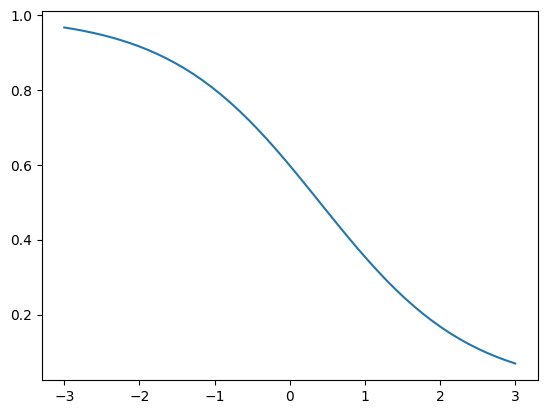

In [509]:
ResponseFunction(elo(
        player_level =0.4,dispersion=1
    )).plot()

In [631]:
initial_difficulty = 0.2
optimal_try_rate = 0.4
player_level = 0.6
response_function = ResponseFunction(elo(
        player_level =player_level,
        dispersion=1
))

In [669]:
experiment_results = Test(
    initial_difficulty = initial_difficulty,
    rounds=1000,
    tries=1_000,
    response_function = response_function,
    update_rule=ProjectedUpdateRule(
        response_rate=0.2,
        optimal_try_rate=optimal_try_rate
    ),
).perform().history
(
    Plotter('Алгоритм спуска с постоянным шагом',)
    .plot_mean(experiment_results)
    .plot_hline(optimal_try_rate)
    .plot_trajectories(experiment_results,3)
    .confidence_interval(experiment_results)
    .show()
)


  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▏     | 422/1000 [00:02<00:03, 173.35it/s]

100%|██████████| 10000/10000 [00:15<00:00, 657.48it/s]


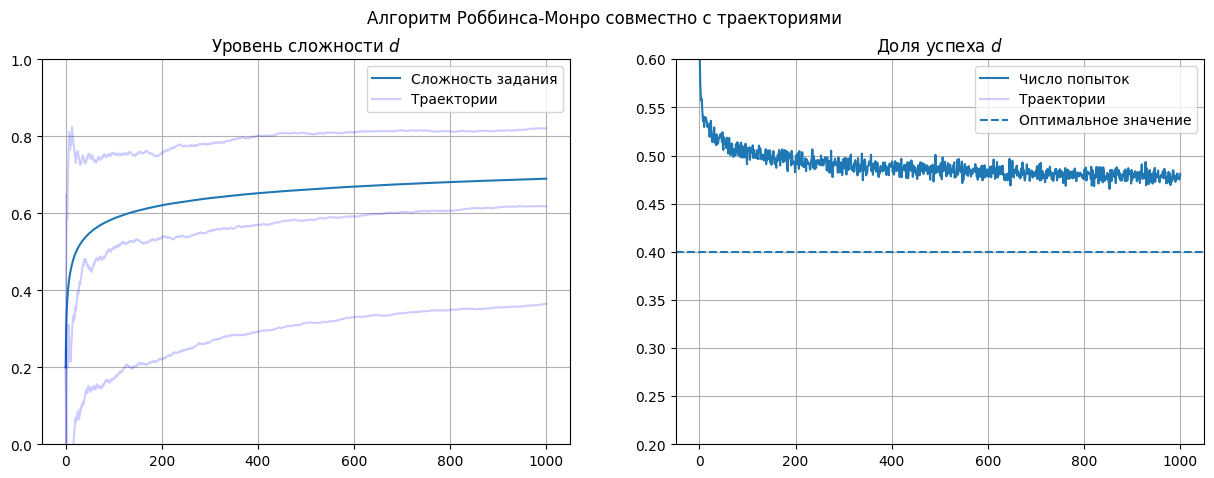

In [661]:
experiment_results = Test(
    initial_difficulty = initial_difficulty,
    rounds=1000,
    tries=10000,
    response_function = response_function,
    update_rule=RobinsUpdateRule(
        response_rate=0.5,
        optimal_try_rate=optimal_try_rate
    ),
).perform().history
(
    Plotter('Алгоритм Роббинса-Монро cовместно с траекториями',)
    .plot_mean(experiment_results)
    .plot_trajectories(experiment_results,3)
    .plot_hline(optimal_try_rate)
    .show()
)

100%|██████████| 10000/10000 [00:15<00:00, 650.78it/s]


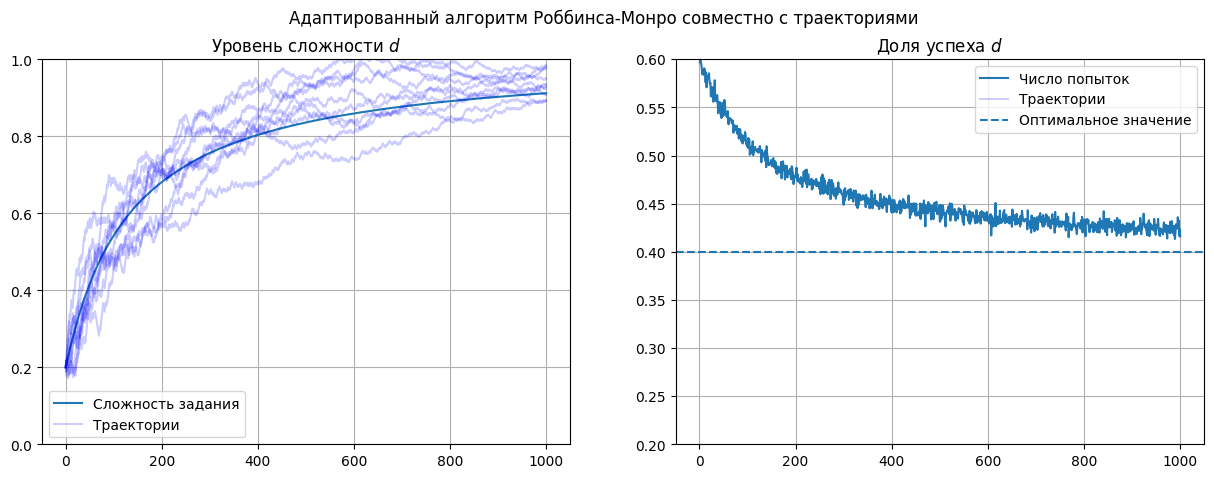

In [660]:
experiment_results = Test(
    initial_difficulty = initial_difficulty,
    rounds=1000,
    tries=10_000,
    response_function = response_function,
    update_rule=AdaptedLogisticRule(
        start_point = initial_difficulty, optimal_try_rate =optimal_try_rate,rounds=1001,
    ),
).perform().history
(
    Plotter('Адаптированный алгоритм Роббинса-Монро cовместно с траекториями',)
    .plot_mean(experiment_results)
    .plot_trajectories(experiment_results,10)
    .plot_hline(optimal_try_rate)
    .show()
)


In [636]:
f = AdaptedLogisticRule(
        start_point = 0.4, optimal_try_rate =0.6
)
print([f(i,0)for i in range(10)])
f.clear()
print([f(i,0)for i in range(10)])

[-0.022441788246031356, 0.9777564436056009, 1.9779512164213142, 2.9781426197442475, 3.978330740058718, 4.978515660919547, 5.978697463074891, 6.97887622458294, 7.979052020922862, 8.979224925100294]
[-0.022441788246031356, 0.9777564436056009, 1.9779512164213142, 2.9781426197442475, 3.978330740058718, 4.978515660919547, 5.978697463074891, 6.97887622458294, 7.979052020922862, 8.979224925100294]


100%|██████████| 500/500 [00:00<00:00, 563.17it/s]


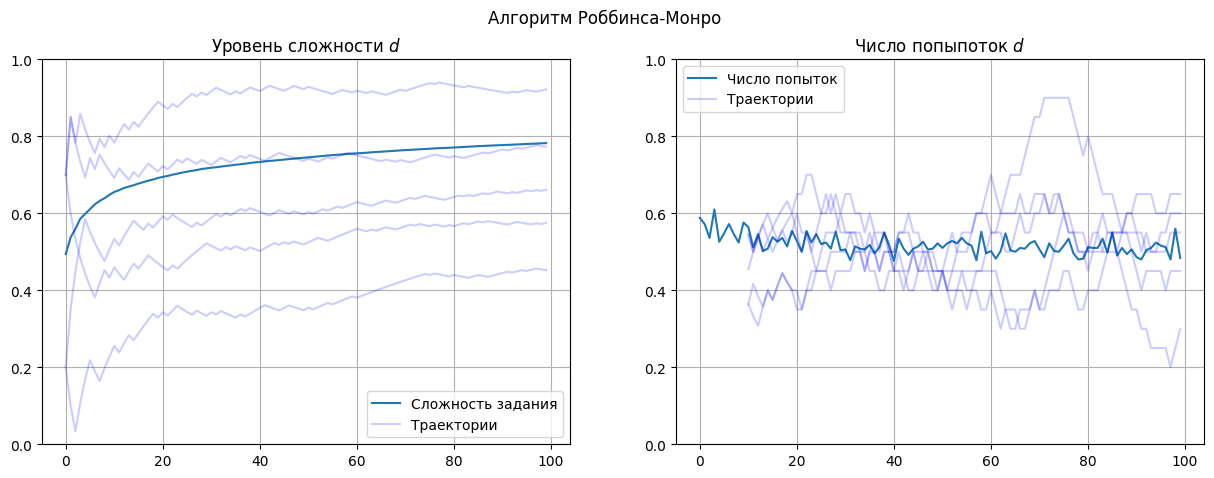

In [468]:
experiment_results = Test(
    initial_difficulty = 0.4,
    rounds=100,
    tries=500,
    response_function = ResponseFunction(elo(
        player_level =0.8,dispersion=1
    )),
    update_rule=RobinsUpdateRule(
        response_rate=0.5,
        optimal_try_rate=0.4
    ),
).perform().history
(
    Plotter('Алгоритм Роббинса-Монро',)
    .plot_mean(experiment_results)
    .plot_trajectories(experiment_results,5)
    .show()
)


In [237]:
Test(
    initial_difficulty = 0.5,
    rounds=100,
    tries=10,
    title='Алгоритм Роббинса-Монро',
    response_function = ResponseFunction(elo(
        player_level =0.5,dispersion=0.01
    )),
    update_rule=PolyakUpdateRule(
        response_rate=0.2,
        optimal_try_rate=0.3
    ),
).perform().plot()

TypeError: descriptor '__init__' requires a 'super' object but received a 'float'

In [ ]:

lambdas = [9]
s_optimal = [0.2,0.5, 0.7]
func 


plt.plot()

Модификация скользящим средним по поляку 
https://pubmed.ncbi.nlm.nih.gov/33014180/